In [4]:
## Author: Gokulan Vigneswaran 20136713

## Team Members ##
#   Jamye Pennino 20153874
#   Eva Mapianda 18153129
#   Nana Appiagyei 20131256

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn is a useful library for Data Visualisation
from statsmodels.graphics.mosaicplot import mosaic
import missingno as msno
from scipy.stats import skewnorm
from sklearn import impute, metrics, model_selection, neighbors, preprocessing, tree


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




---


**Reading Dataset from Drive**



---



In [7]:
perthdata = pd.read_excel('/content/drive/MyDrive/UNI/CMP6202/Group Project/all_perth_310121.xlsx')
#perthdata = pd.read_excel('/all_perth_310121.xlsx')
perthdata.head()

,ADDRESS,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,DATE_SOLD,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,NEAREST_SCH_RANK
0,1 Acorn Place,South Lake,565000,4,2,2.0,600,160,2003.0,18300,Cockburn Central Station,1800,09-2018_x000D_,6164,-32.115900,115.842450,LAKELAND SENIOR HIGH SCHOOL,0.828339,NaN
1,1 Addis Way,Wandi,365000,3,2,2.0,351,139,2013.0,26900,Kwinana Station,4900,02-2019_x000D_,6167,-32.193470,115.859554,ATWELL COLLEGE,5.524324,129.0
2,1 Ainsley Court,Camillo,287000,3,1,1.0,719,86,1979.0,22600,Challis Station,1900,06-2015_x000D_,6111,-32.120578,115.993579,KELMSCOTT SENIOR HIGH SCHOOL,1.649178,113.0
3,1 Albert Street,Bellevue,255000,2,1,2.0,651,59,1953.0,17900,Midland Station,3600,07-2018_x000D_,6056,-31.900547,116.038009,SWAN VIEW SENIOR HIGH SCHOOL,1.571401,NaN
4,1 Aman Place,Lockridge,325000,4,1,2.0,466,131,1998.0,11200,Bassendean Station,2000,11-2016_x000D_,6054,-31.885790,115.947780,KIARA COLLEGE,1.514922,NaN


In [8]:
perthdata.shape

(33656, 19)

In [9]:
perthdata.dtypes

ADDRESS              object
SUBURB               object
PRICE                 int64
BEDROOMS              int64
BATHROOMS             int64
GARAGE              float64
LAND_AREA             int64
FLOOR_AREA            int64
BUILD_YEAR          float64
CBD_DIST              int64
NEAREST_STN          object
NEAREST_STN_DIST      int64
DATE_SOLD            object
POSTCODE              int64
LATITUDE            float64
LONGITUDE           float64
NEAREST_SCH          object
NEAREST_SCH_DIST    float64
NEAREST_SCH_RANK    float64
dtype: object

In [10]:
# Remove the '_x000D_' from the DATE_SOLD column
perthdata['DATE_SOLD'] = perthdata['DATE_SOLD'].str.replace('_x000D_', '')

# Extract the year from the DATE_SOLD column and create a new YEAR_SOLD column
perthdata['YEAR_SOLD'] = pd.to_datetime(perthdata['DATE_SOLD'], format='%m-%Y').dt.year

# Reading CPI data from google drive
cpi_data = pd.read_excel('/content/drive/MyDrive/UNI/CMP6202/Group Project/cpi_data.xlsx')

# Create a lookup table that maps years to CPI values
cpi_lookup = cpi_data.set_index('YEAR')['CPI'].to_dict()

# Define a function that looks up the CPI for a given year
def get_cpi(year):
    return cpi_lookup.get(year, None)

# Apply the get_cpi function to the YEAR_SOLD column
perthdata['CPI'] = perthdata['YEAR_SOLD'].apply(get_cpi)

# Calculate the inflation-adjusted price for each row (2021)
perthdata['ADJUSTED_PRICE'] = perthdata['PRICE'] / perthdata['CPI'] * 124.3

# Convert the ADJUSTED_PRICE column to int
perthdata['ADJUSTED_PRICE'] = perthdata['ADJUSTED_PRICE'].astype(int)

**Reading Consumer Price Index Data From Drive**

In [11]:
perthdata.head()

,ADDRESS,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,...,DATE_SOLD,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,NEAREST_SCH_RANK,YEAR_SOLD,CPI,ADJUSTED_PRICE
0,1 Acorn Place,South Lake,565000,4,2,2.0,600,160,2003.0,18300,...,09-2018,6164,-32.115900,115.842450,LAKELAND SENIOR HIGH SCHOOL,0.828339,NaN,2018,117.9,595670
1,1 Addis Way,Wandi,365000,3,2,2.0,351,139,2013.0,26900,...,02-2019,6167,-32.193470,115.859554,ATWELL COLLEGE,5.524324,129.0,2019,119.8,378710
2,1 Ainsley Court,Camillo,287000,3,1,1.0,719,86,1979.0,22600,...,06-2015,6111,-32.120578,115.993579,KELMSCOTT SENIOR HIGH SCHOOL,1.649178,113.0,2015,112.0,318518
3,1 Albert Street,Bellevue,255000,2,1,2.0,651,59,1953.0,17900,...,07-2018,6056,-31.900547,116.038009,SWAN VIEW SENIOR HIGH SCHOOL,1.571401,NaN,2018,117.9,268842
4,1 Aman Place,Lockridge,325000,4,1,2.0,466,131,1998.0,11200,...,11-2016,6054,-31.885790,115.947780,KIARA COLLEGE,1.514922,NaN,2016,113.5,355925


In [12]:
perthdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33656 entries, 0 to 33655
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ADDRESS           33656 non-null  object 
 1   SUBURB            33656 non-null  object 
 2   PRICE             33656 non-null  int64  
 3   BEDROOMS          33656 non-null  int64  
 4   BATHROOMS         33656 non-null  int64  
 5   GARAGE            31178 non-null  float64
 6   LAND_AREA         33656 non-null  int64  
 7   FLOOR_AREA        33656 non-null  int64  
 8   BUILD_YEAR        30501 non-null  float64
 9   CBD_DIST          33656 non-null  int64  
 10  NEAREST_STN       33656 non-null  object 
 11  NEAREST_STN_DIST  33656 non-null  int64  
 12  DATE_SOLD         33656 non-null  object 
 13  POSTCODE          33656 non-null  int64  
 14  LATITUDE          33656 non-null  float64
 15  LONGITUDE         33656 non-null  float64
 16  NEAREST_SCH       33656 non-null  object

In [13]:
perthdata.describe()

,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH_DIST,NEAREST_SCH_RANK,YEAR_SOLD,CPI,ADJUSTED_PRICE
count,3.365600e+04,33656.000000,33656.000000,31178.000000,33656.000000,33656.000000,30501.000000,33656.000000,33656.000000,33656.000000,33656.000000,33656.000000,33656.000000,22704.000000,33656.000000,33656.000000,3.365600e+04
mean,6.370720e+05,3.659110,1.823063,2.199917,2740.644016,183.501545,1989.706436,19777.374465,4523.371494,6089.420074,-31.960664,115.879265,1.815268,72.672569,2016.621019,114.692159,6.908989e+05
std,3.558256e+05,0.752038,0.587427,1.365225,16693.513215,72.102982,20.964330,11364.415413,4495.064024,62.167921,0.177780,0.118137,1.746000,40.639795,3.505477,7.622611,3.869878e+05
min,5.100000e+04,1.000000,1.000000,1.000000,61.000000,1.000000,1868.000000,681.000000,46.000000,6003.000000,-32.472979,115.582730,0.070912,1.000000,1988.000000,51.800000,5.587700e+04
25%,4.100000e+05,3.000000,1.000000,2.000000,503.000000,130.000000,1978.000000,11200.000000,1800.000000,6050.000000,-32.068437,115.789763,0.880568,39.000000,2015.000000,112.000000,4.414290e+05
50%,5.355000e+05,4.000000,2.000000,2.000000,682.000000,172.000000,1995.000000,17500.000000,3200.000000,6069.000000,-31.933231,115.854198,1.345520,68.000000,2017.000000,115.700000,5.798550e+05
75%,7.600000e+05,4.000000,2.000000,2.000000,838.000000,222.250000,2005.000000,26600.000000,5300.000000,6150.000000,-31.843818,115.970722,2.097225,105.000000,2019.000000,119.800000,8.268410e+05
max,2.440000e+06,10.000000,16.000000,99.000000,999999.000000,870.000000,2017.000000,59800.000000,35500.000000,6558.000000,-31.457450,116.343201,23.254372,139.000000,2020.000000,120.800000,3.364720e+06


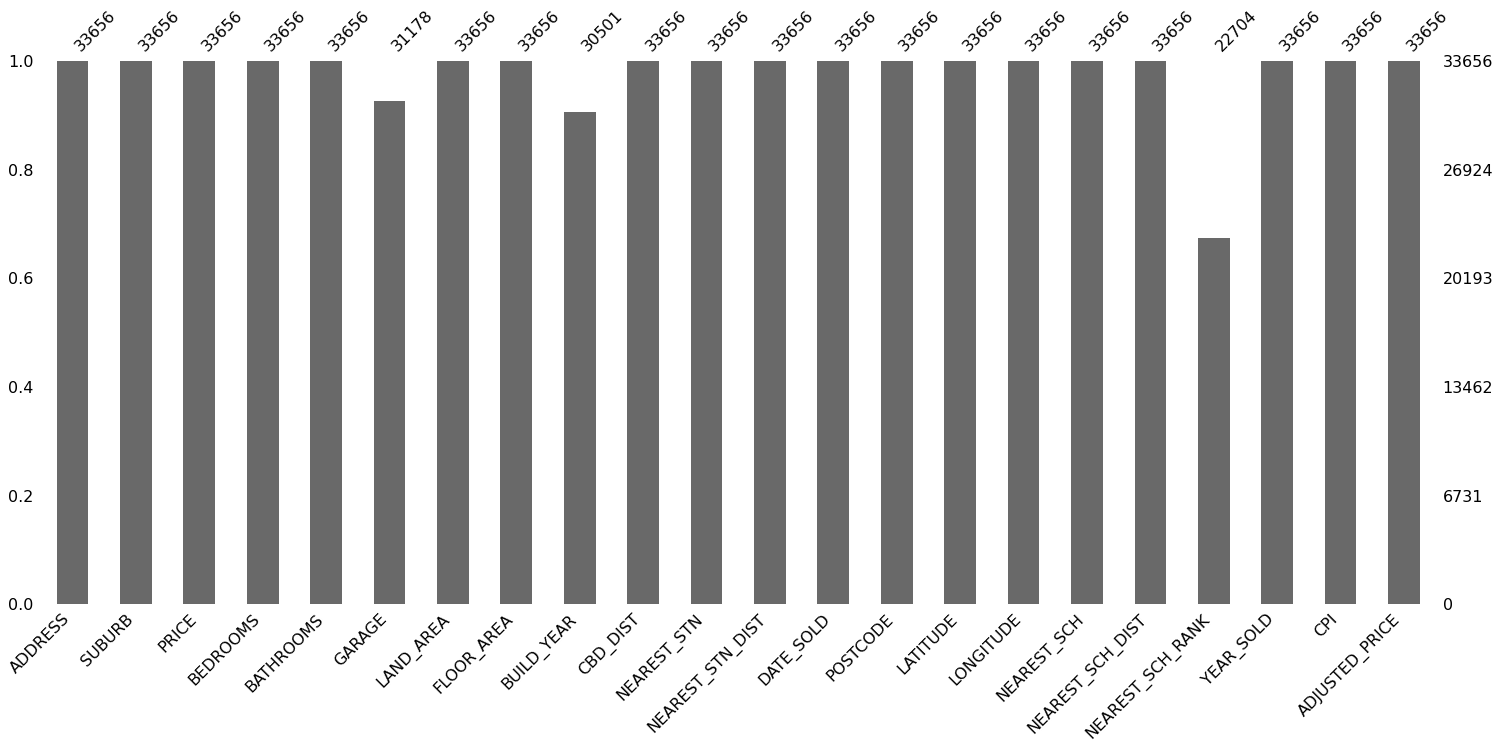

In [14]:
import missingno as msno
# Missingno
msno.bar(perthdata)

**UNIVARIATE ANALYSIS**

In [15]:
perthdata['ADJUSTED_PRICE'].describe().astype(int)

count      33656
mean      690898
std       386987
min        55877
25%       441429
50%       579855
75%       826841
max      3364720
Name: ADJUSTED_PRICE, dtype: int64

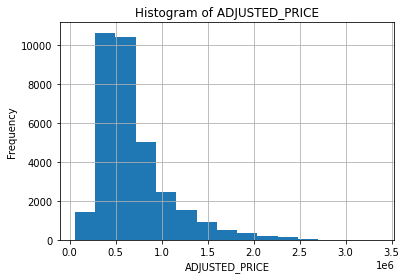

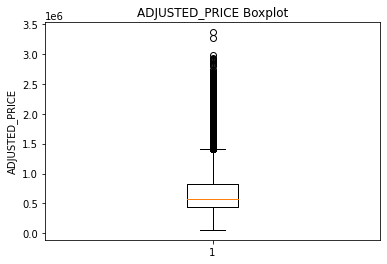

In [16]:
perthdata['ADJUSTED_PRICE'].hist(bins = 15)
plt.xlabel('ADJUSTED_PRICE')
plt.ylabel('Frequency')
plt.title('Histogram of ADJUSTED_PRICE')
plt.show()

plt.boxplot(perthdata['ADJUSTED_PRICE'])
plt.title('ADJUSTED_PRICE Boxplot')
plt.ylabel('ADJUSTED_PRICE')
plt.show()

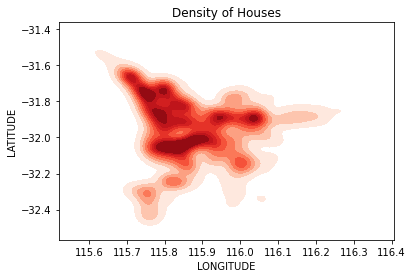

In [17]:
sns.kdeplot(data=perthdata, x='LONGITUDE', y='LATITUDE', cmap="Reds", shade=True, thresh=0.05)
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.title('Density of Houses')
plt.show()

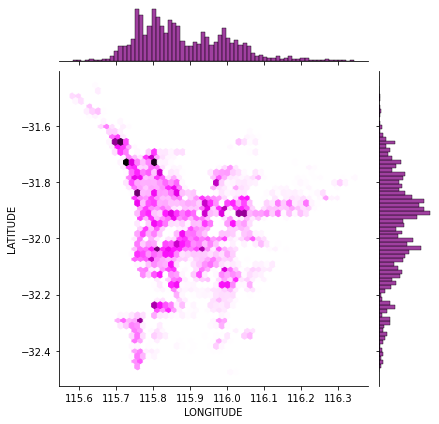

In [18]:
sns.jointplot(x='LONGITUDE', y='LATITUDE', data=perthdata, kind='hex', color='purple', )

In [19]:
perthdata['FLOOR_AREA'].describe().astype(int)

count    33656
mean       183
std         72
min          1
25%        130
50%        172
75%        222
max        870
Name: FLOOR_AREA, dtype: int64

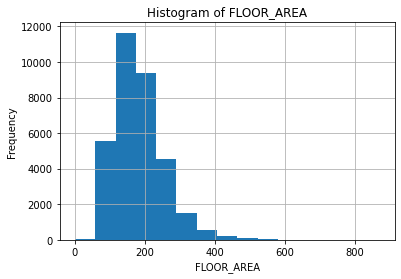

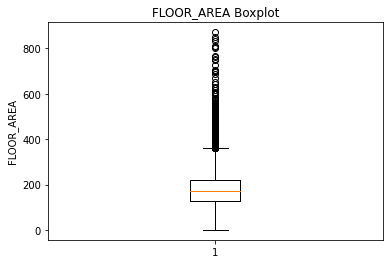

In [20]:
perthdata['FLOOR_AREA'].hist(bins = 15)
plt.xlabel('FLOOR_AREA')
plt.ylabel('Frequency')
plt.title('Histogram of FLOOR_AREA')
plt.show()

plt.boxplot(perthdata['FLOOR_AREA'])
plt.title('FLOOR_AREA Boxplot')
plt.ylabel('FLOOR_AREA')
plt.show()

In [21]:
perthdata['LAND_AREA'].describe().astype(int)

count     33656
mean       2740
std       16693
min          61
25%         503
50%         682
75%         838
max      999999
Name: LAND_AREA, dtype: int64

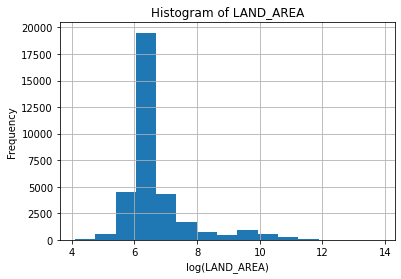

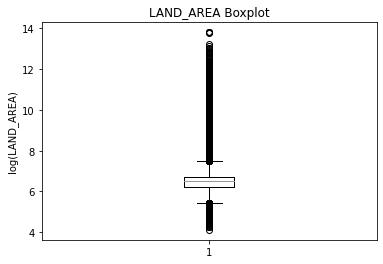

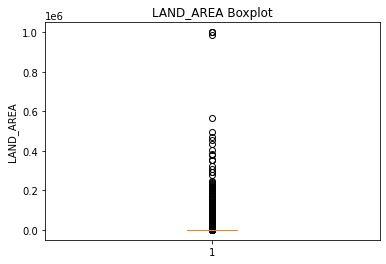

In [22]:
#log transform as very small range
np.log(perthdata['LAND_AREA']).hist(bins = 15)
plt.xlabel('log(LAND_AREA)')
plt.ylabel('Frequency')
plt.title('Histogram of LAND_AREA')
plt.show()

plt.boxplot(np.log(perthdata['LAND_AREA']))
plt.title('LAND_AREA Boxplot')
plt.ylabel('log(LAND_AREA)')
plt.show()


plt.boxplot((perthdata['LAND_AREA']))
plt.title('LAND_AREA Boxplot')
plt.ylabel('LAND_AREA')
plt.show()

In [23]:
perthdata['GARAGE'].describe().astype(int)

count    31178
mean         2
std          1
min          1
25%          2
50%          2
75%          2
max         99
Name: GARAGE, dtype: int64

In [24]:
np.log(perthdata['GARAGE']+1).describe()

count    31178.000000
mean         1.114629
std          0.287521
min          0.693147
25%          1.098612
50%          1.098612
75%          1.098612
max          4.605170
Name: GARAGE, dtype: float64

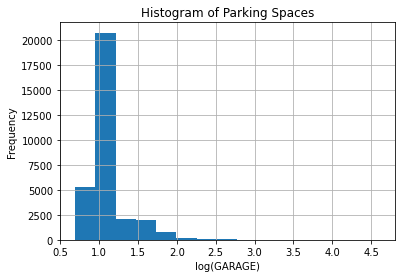

In [25]:
np.log(perthdata['GARAGE']+1).hist(bins = 15)
plt.xlabel('log(GARAGE)')
plt.ylabel('Frequency')
plt.title('Histogram of Parking Spaces')
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


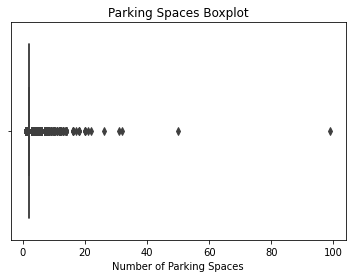

In [26]:
sns.boxplot(perthdata['GARAGE'])
plt.xlabel('Number of Parking Spaces')
plt.title('Parking Spaces Boxplot')
plt.show()

**Bivariate analysis**

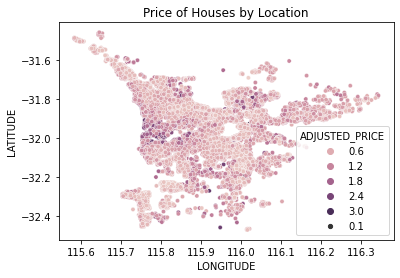

In [27]:
sns.scatterplot(x='LONGITUDE', y='LATITUDE', hue='ADJUSTED_PRICE', size=0.1, data=perthdata)
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.title('Price of Houses by Location')
plt.show()

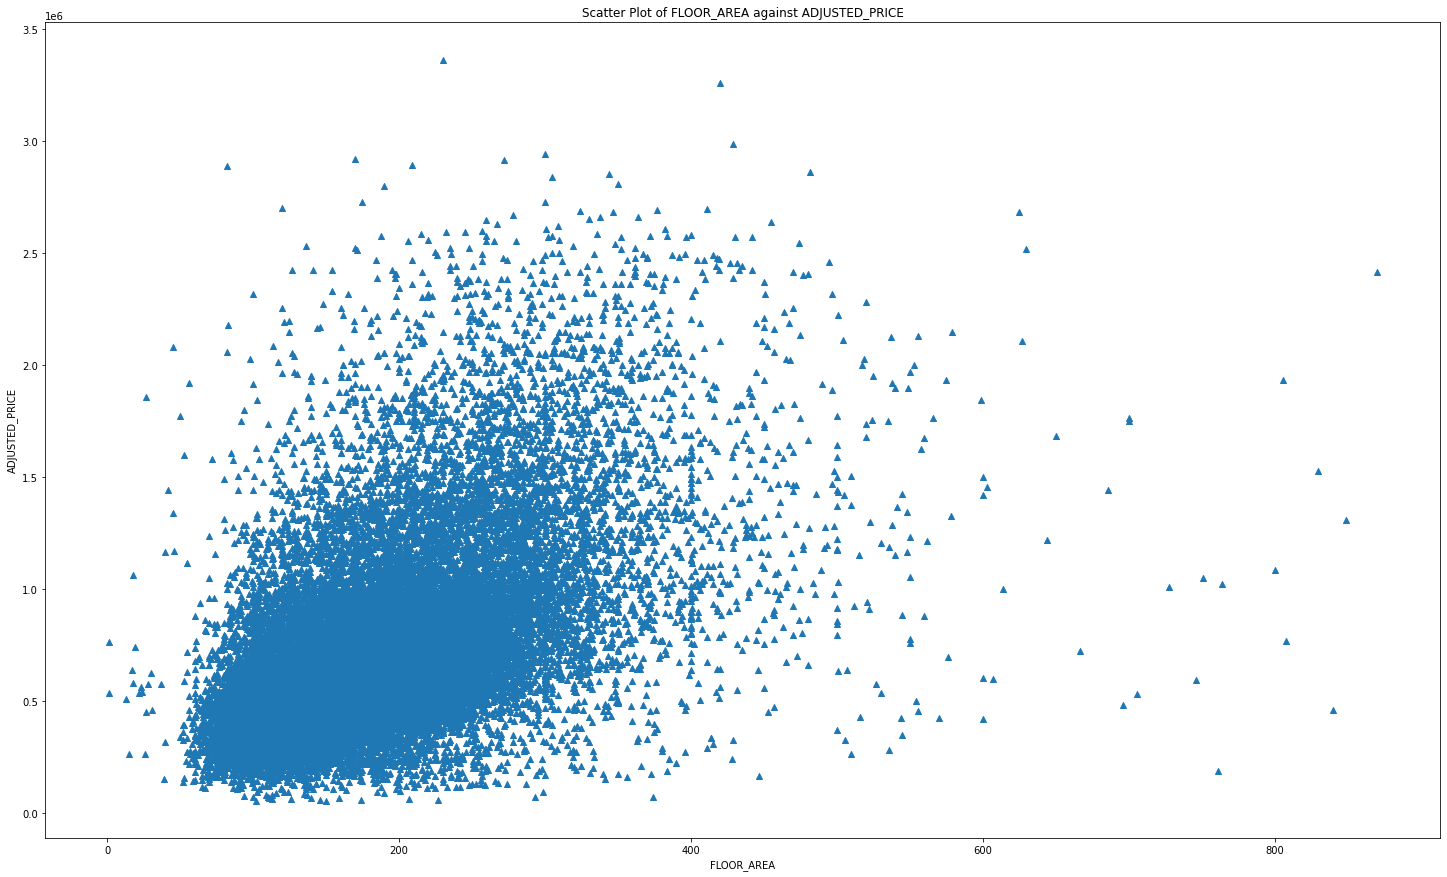

In [28]:
plt.figure(figsize=(25, 15))

plt.scatter((perthdata["FLOOR_AREA"]),(perthdata["ADJUSTED_PRICE"]), marker="^")

plt.xlabel("FLOOR_AREA")

plt.ylabel("ADJUSTED_PRICE")

plt.title("Scatter Plot of FLOOR_AREA against ADJUSTED_PRICE")

plt.show()

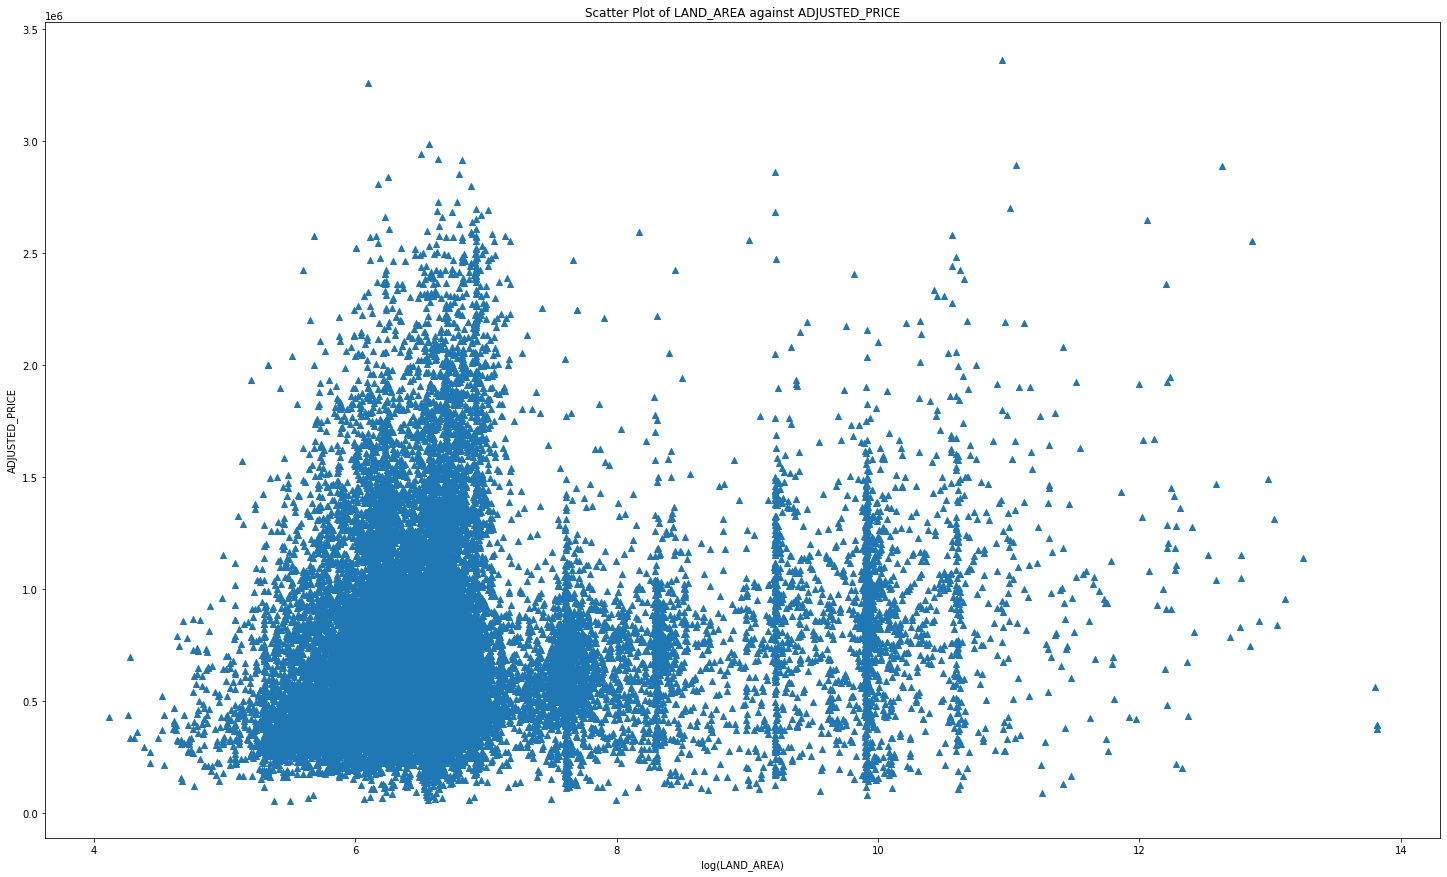

In [29]:
plt.figure(figsize=(25, 15))

plt.scatter((np.log(perthdata["LAND_AREA"])),(perthdata["ADJUSTED_PRICE"]), marker="^")

plt.xlabel("log(LAND_AREA)")

plt.ylabel("ADJUSTED_PRICE")

plt.title("Scatter Plot of LAND_AREA against ADJUSTED_PRICE")

plt.show()

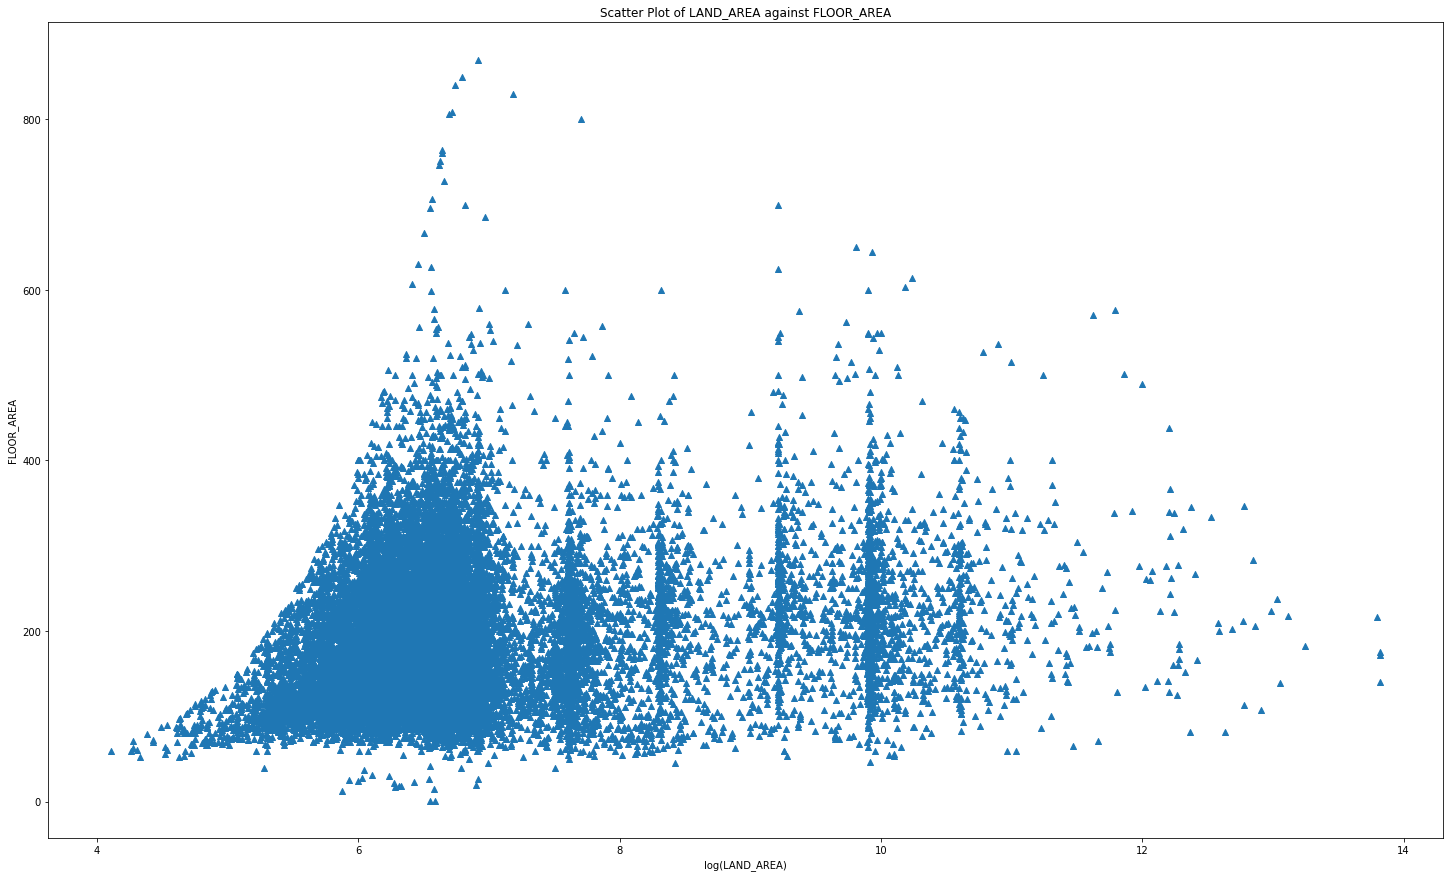

In [30]:
plt.figure(figsize=(25, 15))

plt.scatter((np.log(perthdata["LAND_AREA"])),(perthdata["FLOOR_AREA"]), marker="^")

plt.xlabel("log(LAND_AREA)")

plt.ylabel("FLOOR_AREA")

plt.title("Scatter Plot of LAND_AREA against FLOOR_AREA")

plt.show()

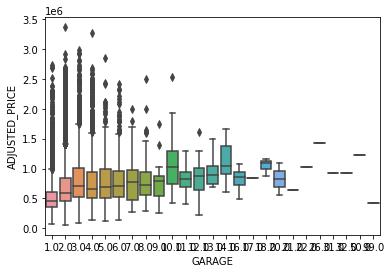

In [31]:
sns.boxplot(x='GARAGE', y='ADJUSTED_PRICE', data=perthdata)
plt.show()

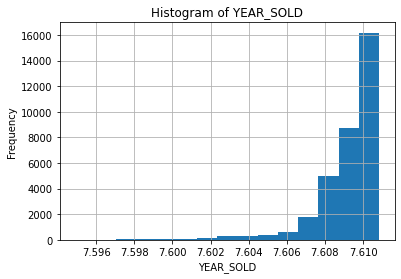

In [32]:

np.log(perthdata['YEAR_SOLD']).hist(bins = 15)
plt.xlabel('YEAR_SOLD')
plt.ylabel('Frequency')
plt.title('Histogram of YEAR_SOLD')
plt.show()

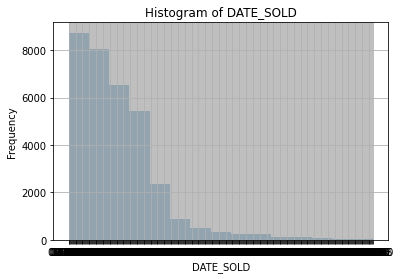

In [33]:

perthdata['DATE_SOLD'].hist(bins = 15)
plt.xlabel('DATE_SOLD')
plt.ylabel('Frequency')
plt.title('Histogram of DATE_SOLD')
plt.show()


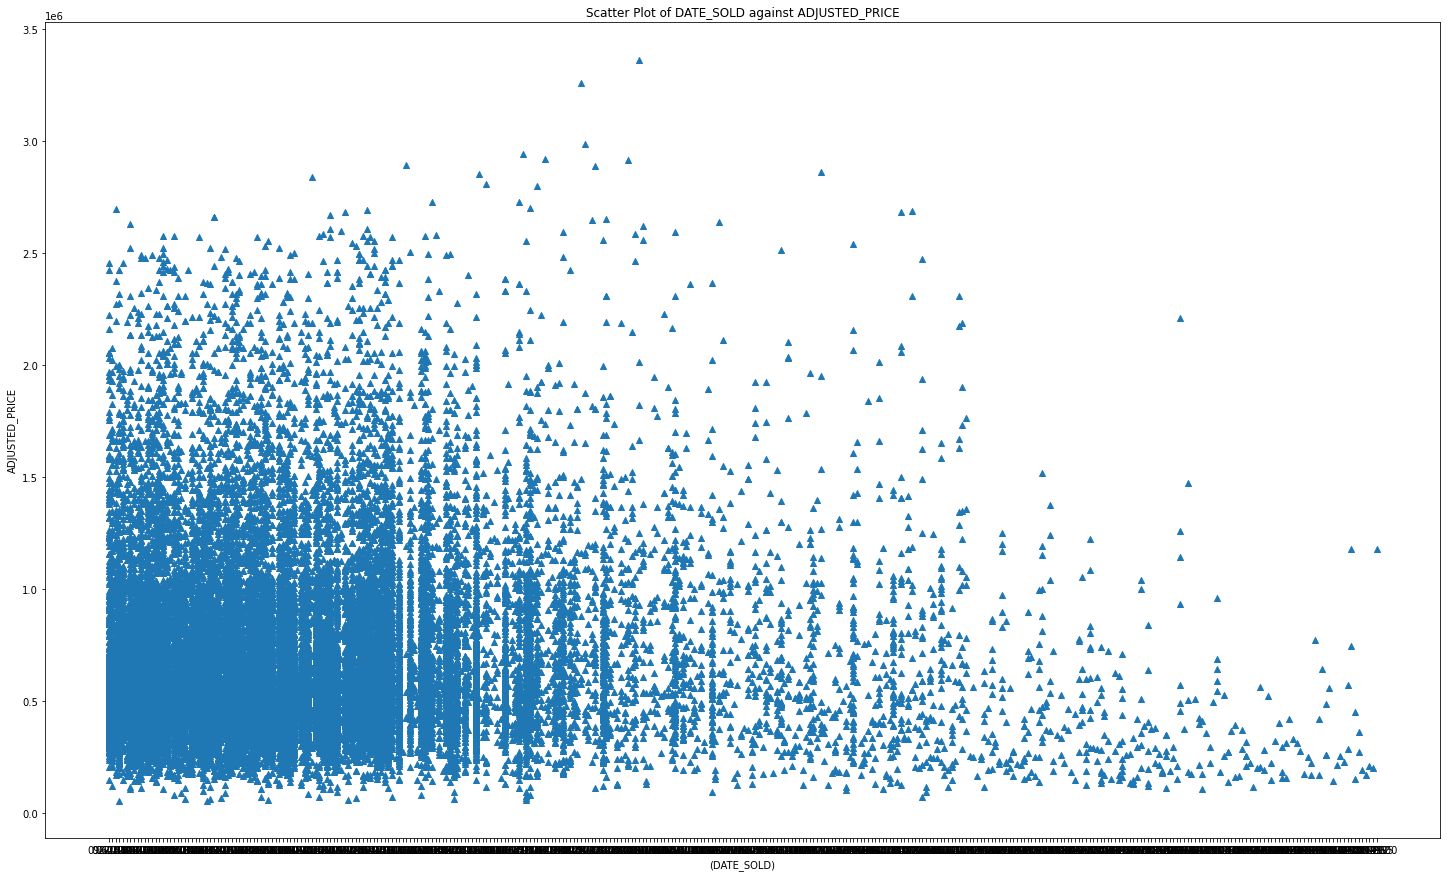

In [34]:
plt.figure(figsize=(25, 15))

plt.scatter(((perthdata["DATE_SOLD"])),(perthdata["ADJUSTED_PRICE"]), marker="^")

plt.xlabel("(DATE_SOLD)")

plt.ylabel("ADJUSTED_PRICE")

plt.title("Scatter Plot of DATE_SOLD against ADJUSTED_PRICE")

plt.show()

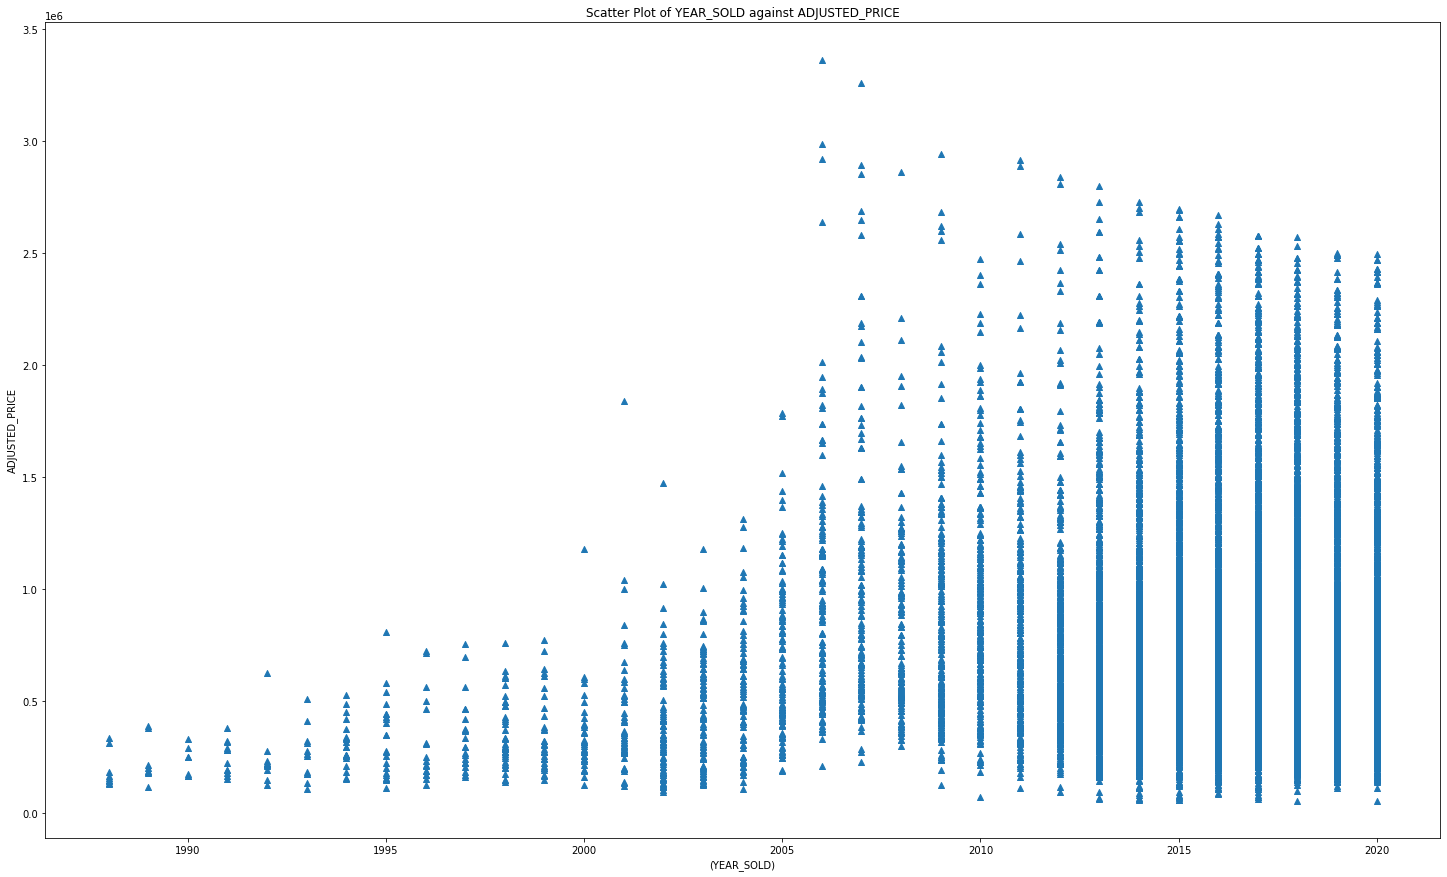

In [35]:
plt.figure(figsize=(25, 15))

plt.scatter(((perthdata["YEAR_SOLD"])),(perthdata["ADJUSTED_PRICE"]), marker="^")

plt.xlabel("(YEAR_SOLD)")

plt.ylabel("ADJUSTED_PRICE")

plt.title("Scatter Plot of YEAR_SOLD against ADJUSTED_PRICE")

plt.show()

In [36]:
perthdata.corr().style.background_gradient(cmap="Reds")

,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH_DIST,NEAREST_SCH_RANK,YEAR_SOLD,CPI,ADJUSTED_PRICE
PRICE,1.000000,0.252637,0.377133,0.134343,0.056855,0.548497,-0.157218,-0.354327,-0.095089,-0.171553,0.053041,-0.183734,-0.021941,-0.461991,0.073894,0.081829,0.992573
BEDROOMS,0.252637,1.000000,0.555702,0.194197,0.051223,0.536926,0.229019,0.124654,0.102203,0.010601,0.021967,-0.015170,0.092391,0.024461,0.003505,0.003073,0.253416
BATHROOMS,0.377133,0.555702,1.000000,0.186801,0.027059,0.555843,0.339594,0.033053,0.037068,-0.041374,0.051411,-0.093817,0.060734,-0.096024,0.052684,0.051736,0.372880
GARAGE,0.134343,0.194197,0.186801,1.000000,0.059211,0.201541,0.040371,0.046244,0.110527,0.028005,-0.016416,0.091270,0.099654,0.021863,-0.016381,-0.011897,0.135665
LAND_AREA,0.056855,0.051223,0.027059,0.059211,1.000000,0.073836,0.002063,0.133262,0.233023,0.042070,-0.014389,0.151255,0.286964,0.048758,-0.164746,-0.169223,0.078920
FLOOR_AREA,0.548497,0.536926,0.555843,0.201541,0.073836,1.000000,0.226872,0.022687,0.106527,-0.050658,0.043555,-0.046625,0.120048,-0.145502,-0.057976,-0.065248,0.553723
BUILD_YEAR,-0.157218,0.229019,0.339594,0.040371,0.002063,0.226872,1.000000,0.270110,0.103350,0.044095,0.045463,-0.059047,0.108719,0.158639,0.080254,0.076967,-0.162303
CBD_DIST,-0.354327,0.124654,0.033053,0.046244,0.133262,0.022687,0.270110,1.000000,0.446496,0.255801,-0.196813,-0.060097,0.377118,0.328703,-0.048633,-0.053889,-0.345236
NEAREST_STN_DIST,-0.095089,0.102203,0.037068,0.110527,0.233023,0.106527,0.103350,0.446496,1.000000,0.204347,0.037174,0.496924,0.634712,0.189571,-0.203267,-0.207274,-0.073541
POSTCODE,-0.171553,0.010601,-0.041374,0.028005,0.042070,-0.050658,0.044095,0.255801,0.204347,1.000000,-0.642643,0.173918,0.128424,0.192768,-0.055230,-0.051354,-0.164962


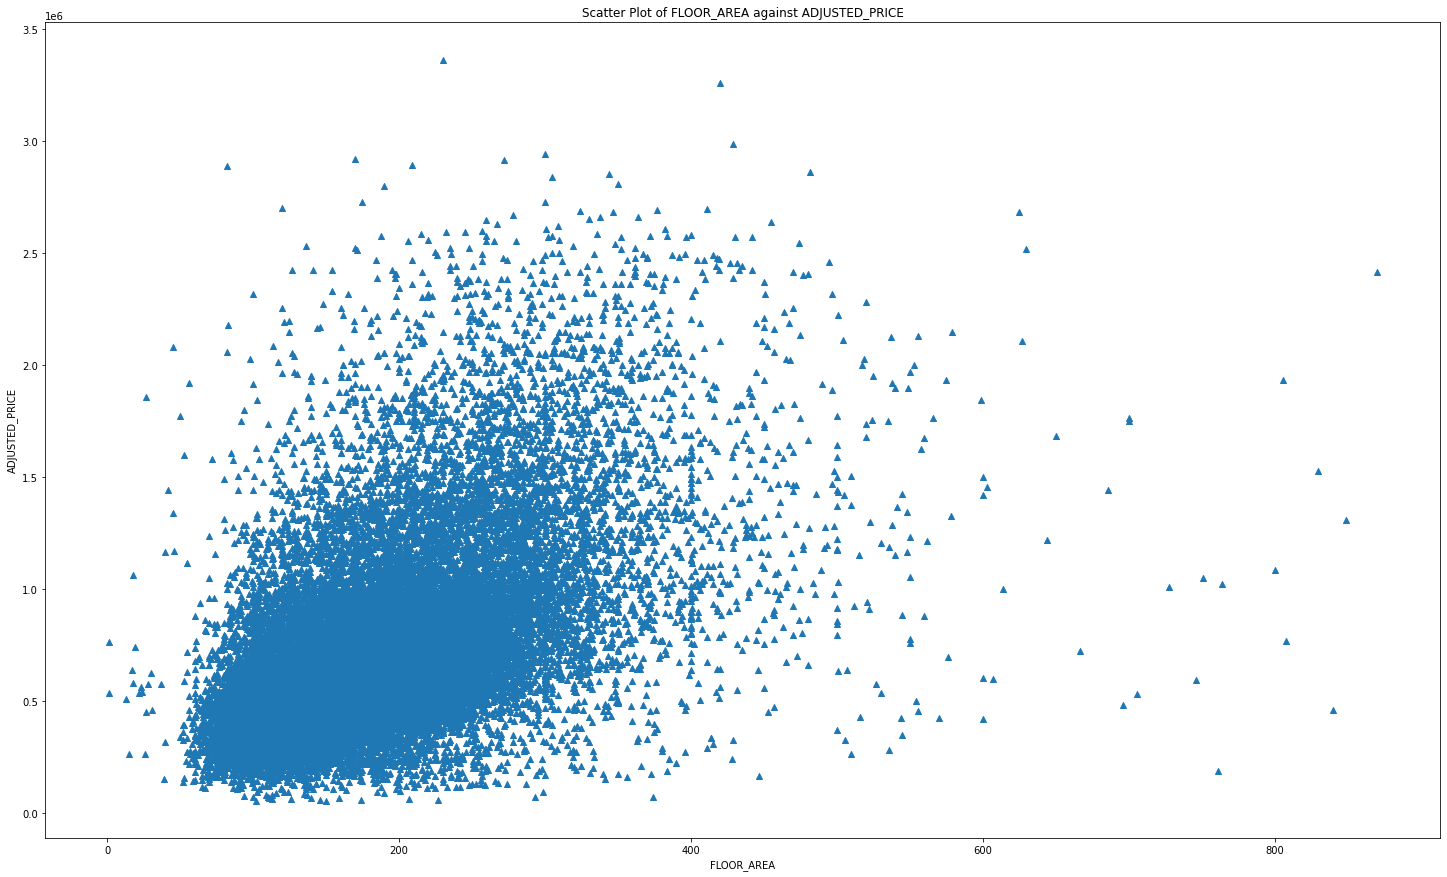

In [37]:
plt.figure(figsize=(25, 15))

plt.scatter((perthdata["FLOOR_AREA"]),(perthdata["ADJUSTED_PRICE"]), marker="^")

plt.xlabel("FLOOR_AREA")

plt.ylabel("ADJUSTED_PRICE")

plt.title("Scatter Plot of FLOOR_AREA against ADJUSTED_PRICE")

plt.show()



---


**Splitting Dataset**



---



In [38]:
from sklearn.model_selection import train_test_split

X = perthdata.drop(columns=['PRICE'], axis=1)
y = perthdata['ADJUSTED_PRICE']

X_train, X_testvalid, y_train, y_testvalid = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state= 42)

X_valid, X_test, y_valid, y_test = train_test_split(X_testvalid, y_testvalid, train_size=0.65, test_size=0.35, random_state= 42)



---


**Cleaning X_train**


---



In [39]:
#Checking for missing values
X_train.isna().sum()

ADDRESS                0
SUBURB                 0
BEDROOMS               0
BATHROOMS              0
GARAGE              1978
LAND_AREA              0
FLOOR_AREA             0
BUILD_YEAR          2545
CBD_DIST               0
NEAREST_STN            0
NEAREST_STN_DIST       0
DATE_SOLD              0
POSTCODE               0
LATITUDE               0
LONGITUDE              0
NEAREST_SCH            0
NEAREST_SCH_DIST       0
NEAREST_SCH_RANK    8747
YEAR_SOLD              0
CPI                    0
ADJUSTED_PRICE         0
dtype: int64

In [40]:
#Removing nearest school rank as it has too many missing values to impute accurately
X_train = X_train.drop(columns=["NEAREST_SCH_RANK"], axis = 1)

#Imputing Missing Values
X_train = X_train.fillna(X_train.mean())

#Checking that there are now no empty values*
X_train.isna().sum()

<ipython-input-40-136dd48a73c5>:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X_train = X_train.fillna(X_train.mean())


ADDRESS             0
SUBURB              0
BEDROOMS            0
BATHROOMS           0
GARAGE              0
LAND_AREA           0
FLOOR_AREA          0
BUILD_YEAR          0
CBD_DIST            0
NEAREST_STN         0
NEAREST_STN_DIST    0
DATE_SOLD           0
POSTCODE            0
LATITUDE            0
LONGITUDE           0
NEAREST_SCH         0
NEAREST_SCH_DIST    0
YEAR_SOLD           0
CPI                 0
ADJUSTED_PRICE      0
dtype: int64

In [41]:
#Categorical function puts all values that are strings in an array
from pandas.core.arrays import categorical
categorical = [i for i in X_train.columns if X_train[i].dtype == 'object']

#Making an array that contains the frequencies of unique values in each of the categorical variables
unique_values = [X_train[j].nunique() for j in categorical]

#Creating dataframe to see how many unique values there are in each of the categorical variables
categorical_data = pd.DataFrame({"Name":categorical, "Unique Value Sum":unique_values})
categorical_data

,Name,Unique Value Sum
0,ADDRESS,26871
1,SUBURB,321
2,NEAREST_STN,68
3,DATE_SOLD,342
4,NEAREST_SCH,160


In [42]:
#Dropping ADDRESS as it has too many unique variables
#Dropping DATE_SOLD as it cannot be ranked
X_train = X_train.drop(columns=['ADDRESS', 'DATE_SOLD'], axis=1)

#Checking columns have been removed
X_train.columns

Index(['SUBURB', 'BEDROOMS', 'BATHROOMS', 'GARAGE', 'LAND_AREA', 'FLOOR_AREA',
       'BUILD_YEAR', 'CBD_DIST', 'NEAREST_STN', 'NEAREST_STN_DIST', 'POSTCODE',
       'LATITUDE', 'LONGITUDE', 'NEAREST_SCH', 'NEAREST_SCH_DIST', 'YEAR_SOLD',
       'CPI', 'ADJUSTED_PRICE'],
      dtype='object')

In [43]:

# Using Ordinal Encoder to turn remain categorical variables into numerical values
from sklearn.preprocessing import OrdinalEncoder
#############################################################

# Group the data by SUBURB and calculate the average ADJUSTED_PRICE
grouped_sub = X_train.groupby('SUBURB')['ADJUSTED_PRICE'].mean()

# Sort the suburbs by average ADJUSTED_PRICE in ascending order
sorted_suburbs = grouped_sub.sort_values()

# Create an ordinal encoder
encoder = OrdinalEncoder()

# Encode the SUBURB column using the sorted_suburbs index
X_train['SUBURB_RANK'] = encoder.fit_transform(X_train[['SUBURB']], sorted_suburbs.index)

##############################################################

# Group the data by NEAREST_STN and calculate the average ADJUSTED_PRICE
grouped_stn = X_train.groupby('NEAREST_STN')['ADJUSTED_PRICE'].mean()

# Sort the suburbs by average ADJUSTED_PRICE in ascending order
sorted_stations = grouped_stn.sort_values()

# Create an ordinal encoder
encoder = OrdinalEncoder()

# Encode the NEAREST_STN column using the sorted_suburbs index
X_train['NEAREST_STN_RANK'] = encoder.fit_transform(X_train[['NEAREST_STN']], sorted_stations.index)

##############################################################

# Group the data by NEAREST_SCH and calculate the average ADJUSTED_PRICE
grouped_sch = X_train.groupby('NEAREST_SCH')['ADJUSTED_PRICE'].mean()

# Sort the suburbs by average ADJUSTED_PRICE in ascending order
sorted_schools = grouped_sch.sort_values()

# Create an ordinal encoder
encoder = OrdinalEncoder()

# Encode the NEAREST_STN column using the sorted_suburbs index
X_train['NEAREST_SCH_RANK'] = encoder.fit_transform(X_train[['NEAREST_SCH']], sorted_schools.index)

#############################################################

X_train_1 = X_train

# Dropping ADJUSTED_PRICE and remaining categorical varibales as they are no longer neccessary
X_train = X_train.drop(columns=['ADJUSTED_PRICE', 'SUBURB', 'NEAREST_STN', 'NEAREST_SCH'], axis=1)

#Checking all variables are now numerical data types
X_train.dtypes


BEDROOMS              int64
BATHROOMS             int64
GARAGE              float64
LAND_AREA             int64
FLOOR_AREA            int64
BUILD_YEAR          float64
CBD_DIST              int64
NEAREST_STN_DIST      int64
POSTCODE              int64
LATITUDE            float64
LONGITUDE           float64
NEAREST_SCH_DIST    float64
YEAR_SOLD             int64
CPI                 float64
SUBURB_RANK         float64
NEAREST_STN_RANK    float64
NEAREST_SCH_RANK    float64
dtype: object

In [44]:
X_train.head()

,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH_DIST,YEAR_SOLD,CPI,SUBURB_RANK,NEAREST_STN_RANK,NEAREST_SCH_RANK
9451,4,2,2.000000,866,200,1991.0,21400,4000,6025,-31.787730,115.742420,1.197313,2020,120.8,150.0,66.0,138.0
6534,4,2,2.197146,447,199,2011.0,38700,379,6036,-31.632017,115.700832,2.308836,2018,117.9,50.0,8.0,17.0
431,5,3,2.000000,60024,236,1990.0,24000,12800,6076,-32.002980,116.106730,1.772472,2009,97.2,38.0,38.0,23.0
11544,4,2,2.000000,260,157,2000.0,16000,2600,6162,-32.070070,115.761760,0.633567,2017,115.7,24.0,25.0,50.0
12785,4,2,2.000000,423,285,2011.0,8000,2100,6152,-32.023070,115.872250,1.048352,2016,113.5,251.0,10.0,4.0


In [45]:

#Using MinMaxScaler to make all values between 0 and 1
#Saving an unscaled version of Y to compare predictions

from sklearn.preprocessing import MinMaxScaler 

minmax = MinMaxScaler()
minmax_y = MinMaxScaler()
y_train_unscaled = y_train


X_train[list(X_train.columns)] = minmax.fit_transform(X_train[list(X_train.columns)])
y_train=minmax_y.fit_transform(pd.DataFrame({'price':y_train}))

#Checking all variables have been scaled
X_train.head()

,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH_DIST,YEAR_SOLD,CPI,SUBURB_RANK,NEAREST_STN_RANK,NEAREST_SCH_RANK
9451,0.333333,0.166667,0.010204,0.000805,0.218203,0.823129,0.350463,0.111525,0.039640,0.674746,0.209988,0.048586,1.00000,1.000000,0.468750,0.985075,0.867925
6534,0.333333,0.166667,0.012216,0.000386,0.217036,0.959184,0.643093,0.009392,0.059459,0.828090,0.155301,0.096531,0.93750,0.957971,0.156250,0.119403,0.106918
431,0.444444,0.333333,0.010204,0.059967,0.260210,0.816327,0.394442,0.359734,0.131532,0.462772,0.689047,0.073395,0.65625,0.657971,0.118750,0.567164,0.144654
11544,0.333333,0.166667,0.010204,0.000199,0.168028,0.884354,0.259121,0.072037,0.286486,0.396703,0.235420,0.024270,0.90625,0.926087,0.075000,0.373134,0.314465
12785,0.333333,0.166667,0.010204,0.000362,0.317386,0.959184,0.123801,0.057934,0.268468,0.442987,0.380711,0.042161,0.87500,0.894203,0.784375,0.149254,0.025157


---


**Cleaning X_test**


---

In [46]:
X_test = X_test.drop(columns=["NEAREST_SCH_RANK"], axis = 1)
X_test = X_test.fillna(X_test.mean())
X_test.isna().sum()

<ipython-input-46-be4ea2df8428>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X_test = X_test.fillna(X_test.mean())


ADDRESS             0
SUBURB              0
BEDROOMS            0
BATHROOMS           0
GARAGE              0
LAND_AREA           0
FLOOR_AREA          0
BUILD_YEAR          0
CBD_DIST            0
NEAREST_STN         0
NEAREST_STN_DIST    0
DATE_SOLD           0
POSTCODE            0
LATITUDE            0
LONGITUDE           0
NEAREST_SCH         0
NEAREST_SCH_DIST    0
YEAR_SOLD           0
CPI                 0
ADJUSTED_PRICE      0
dtype: int64

In [47]:
categorical = [i for i in X_test.columns if X_test[i].dtype == 'object']

unique_values = [X_test[j].nunique() for j in categorical]

categorical_data = pd.DataFrame({"Name":categorical, "Unique Value Sum":unique_values})
categorical_data

,Name,Unique Value Sum
0,ADDRESS,2357
1,SUBURB,303
2,NEAREST_STN,67
3,DATE_SOLD,203
4,NEAREST_SCH,155


In [48]:
X_test = X_test.drop(columns=['ADDRESS', 'DATE_SOLD'], axis=1)
X_test.columns

Index(['SUBURB', 'BEDROOMS', 'BATHROOMS', 'GARAGE', 'LAND_AREA', 'FLOOR_AREA',
       'BUILD_YEAR', 'CBD_DIST', 'NEAREST_STN', 'NEAREST_STN_DIST', 'POSTCODE',
       'LATITUDE', 'LONGITUDE', 'NEAREST_SCH', 'NEAREST_SCH_DIST', 'YEAR_SOLD',
       'CPI', 'ADJUSTED_PRICE'],
      dtype='object')

In [49]:
# Group the data by SUBURB and calculate the average ADJUSTED_PRICE
grouped_sub = X_test.groupby('SUBURB')['ADJUSTED_PRICE'].mean()

# Sort the suburbs by average ADJUSTED_PRICE in ascending order
sorted_suburbs = grouped_sub.sort_values()

# Create an ordinal encoder
encoder = OrdinalEncoder()

# Encode the SUBURB column using the sorted_suburbs index
X_test['SUBURB_RANK'] = encoder.fit_transform(X_test[['SUBURB']], sorted_suburbs.index)

##############################################################

# Group the data by NEAREST_STN and calculate the average ADJUSTED_PRICE
grouped_stn = X_test.groupby('NEAREST_STN')['ADJUSTED_PRICE'].mean()

# Sort the suburbs by average ADJUSTED_PRICE in ascending order
sorted_stations = grouped_stn.sort_values()

# Create an ordinal encoder
encoder = OrdinalEncoder()

# Encode the NEAREST_STN column using the sorted_suburbs index
X_test['NEAREST_STN_RANK'] = encoder.fit_transform(X_test[['NEAREST_STN']], sorted_stations.index)

#############################################################

# Group the data by NEAREST_SCH and calculate the average ADJUSTED_PRICE
grouped_sch = X_test.groupby('NEAREST_SCH')['ADJUSTED_PRICE'].mean()

# Sort the suburbs by average ADJUSTED_PRICE in ascending order
sorted_schools = grouped_sch.sort_values()

# Create an ordinal encoder
encoder = OrdinalEncoder()

# Encode the NEAREST_STN column using the sorted_suburbs index
X_test['NEAREST_SCH_RANK'] = encoder.fit_transform(X_test[['NEAREST_SCH']], sorted_schools.index)

#############################################################

X_test_1 = X_test

X_test = X_test.drop(columns=['ADJUSTED_PRICE', 'SUBURB', 'NEAREST_STN', 'NEAREST_SCH'], axis=1)

X_test.dtypes

BEDROOMS              int64
BATHROOMS             int64
GARAGE              float64
LAND_AREA             int64
FLOOR_AREA            int64
BUILD_YEAR          float64
CBD_DIST              int64
NEAREST_STN_DIST      int64
POSTCODE              int64
LATITUDE            float64
LONGITUDE           float64
NEAREST_SCH_DIST    float64
YEAR_SOLD             int64
CPI                 float64
SUBURB_RANK         float64
NEAREST_STN_RANK    float64
NEAREST_SCH_RANK    float64
dtype: object

In [50]:
y_test_unscaled = y_test
X_test[list(X_test.columns)] = minmax.fit_transform(X_test[list(X_test.columns)])
y_test=minmax_y.fit_transform(pd.DataFrame({'price':y_test}))
X_test.head()

,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH_DIST,YEAR_SOLD,CPI,SUBURB_RANK,NEAREST_STN_RANK,NEAREST_SCH_RANK
2310,0.428571,0.2,0.066667,0.000587,0.217266,0.932886,0.218085,0.258682,0.099099,0.500108,0.569506,0.050951,1.00000,1.000000,0.331126,0.636364,0.253247
7431,0.285714,0.2,0.066667,0.000325,0.194245,0.986577,0.955674,0.283601,0.311712,0.003246,0.245036,0.177175,0.81250,0.849275,0.493377,0.575758,0.207792
5766,0.428571,0.2,0.066667,0.000600,0.358273,0.798658,0.281915,0.059337,0.190991,0.412535,0.565615,0.097872,0.90625,0.926087,0.562914,0.560606,0.850649
23160,0.428571,0.0,0.000000,0.000614,0.172662,0.812081,0.567376,0.037533,0.295495,0.203584,0.321332,0.039372,0.90625,0.926087,0.735099,0.939394,0.681818
4405,0.428571,0.0,0.000000,0.000858,0.188489,0.617450,0.108156,0.078025,0.178378,0.454152,0.431630,0.031333,0.87500,0.894203,0.112583,0.954545,0.123377


---


**Cleaning X_valid**


---

In [51]:
X_valid = X_valid.drop(columns=["NEAREST_SCH_RANK"], axis = 1)
X_valid = X_valid.fillna(X_valid.mean())
X_valid.isna().sum()

<ipython-input-51-8b99a019b7db>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X_valid = X_valid.fillna(X_valid.mean())


ADDRESS             0
SUBURB              0
BEDROOMS            0
BATHROOMS           0
GARAGE              0
LAND_AREA           0
FLOOR_AREA          0
BUILD_YEAR          0
CBD_DIST            0
NEAREST_STN         0
NEAREST_STN_DIST    0
DATE_SOLD           0
POSTCODE            0
LATITUDE            0
LONGITUDE           0
NEAREST_SCH         0
NEAREST_SCH_DIST    0
YEAR_SOLD           0
CPI                 0
ADJUSTED_PRICE      0
dtype: int64

In [52]:
categorical = [i for i in X_valid.columns if X_valid[i].dtype == 'object']
unique_values = [X_valid[j].nunique() for j in categorical]
categorical_data = pd.DataFrame({"Name":categorical, "Unique Value Sum":unique_values})
categorical_data

,Name,Unique Value Sum
0,ADDRESS,4373
1,SUBURB,315
2,NEAREST_STN,67
3,DATE_SOLD,234
4,NEAREST_SCH,158


In [53]:
X_valid = X_valid.drop(columns=['ADDRESS', 'DATE_SOLD'], axis=1)
X_valid.columns

Index(['SUBURB', 'BEDROOMS', 'BATHROOMS', 'GARAGE', 'LAND_AREA', 'FLOOR_AREA',
       'BUILD_YEAR', 'CBD_DIST', 'NEAREST_STN', 'NEAREST_STN_DIST', 'POSTCODE',
       'LATITUDE', 'LONGITUDE', 'NEAREST_SCH', 'NEAREST_SCH_DIST', 'YEAR_SOLD',
       'CPI', 'ADJUSTED_PRICE'],
      dtype='object')

In [54]:
# Group the data by SUBURB and calculate the average ADJUSTED_PRICE
grouped_sub = X_valid.groupby('SUBURB')['ADJUSTED_PRICE'].mean()

# Sort the suburbs by average ADJUSTED_PRICE in ascending order
sorted_suburbs = grouped_sub.sort_values()

# Create an ordinal encoder
encoder = OrdinalEncoder()

# Encode the SUBURB column using the sorted_suburbs index
X_valid['SUBURB_RANK'] = encoder.fit_transform(X_valid[['SUBURB']], sorted_suburbs.index)

##############################################################

# Group the data by NEAREST_STN and calculate the average ADJUSTED_PRICE
grouped_stn = X_valid.groupby('NEAREST_STN')['ADJUSTED_PRICE'].mean()

# Sort the suburbs by average ADJUSTED_PRICE in ascending order
sorted_stations = grouped_stn.sort_values()

# Create an ordinal encoder
encoder = OrdinalEncoder()

# Encode the NEAREST_STN column using the sorted_suburbs index
X_valid['NEAREST_STN_RANK'] = encoder.fit_transform(X_valid[['NEAREST_STN']], sorted_stations.index)

##############################################################

# Group the data by NEAREST_SCH and calculate the average ADJUSTED_PRICE
grouped_sch = X_valid.groupby('NEAREST_SCH')['ADJUSTED_PRICE'].mean()

# Sort the suburbs by average ADJUSTED_PRICE in ascending order
sorted_schools = grouped_sch.sort_values()

# Create an ordinal encoder
encoder = OrdinalEncoder()

# Encode the NEAREST_STN column using the sorted_suburbs index
X_valid['NEAREST_SCH_RANK'] = encoder.fit_transform(X_valid[['NEAREST_SCH']], sorted_schools.index)

##############################################################
X_valid_1 = X_valid

X_valid = X_valid.drop(columns=['ADJUSTED_PRICE', 'SUBURB', 'NEAREST_STN', 'NEAREST_SCH'], axis=1)

X_valid.dtypes

BEDROOMS              int64
BATHROOMS             int64
GARAGE              float64
LAND_AREA             int64
FLOOR_AREA            int64
BUILD_YEAR          float64
CBD_DIST              int64
NEAREST_STN_DIST      int64
POSTCODE              int64
LATITUDE            float64
LONGITUDE           float64
NEAREST_SCH_DIST    float64
YEAR_SOLD             int64
CPI                 float64
SUBURB_RANK         float64
NEAREST_STN_RANK    float64
NEAREST_SCH_RANK    float64
dtype: object

In [55]:
y_valid_unscaled = y_valid
X_valid[list(X_valid.columns)] = minmax.fit_transform(X_valid[list(X_valid.columns)])
y_valid=minmax_y.fit_transform(pd.DataFrame({'price':y_valid}))


list(X_valid.columns)
X_valid.head()

,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH_DIST,YEAR_SOLD,CPI,SUBURB_RANK,NEAREST_STN_RANK,NEAREST_SCH_RANK
29521,0.250,0.000000,0.333333,0.000493,0.125172,0.809524,0.172449,0.102911,0.091892,0.591129,0.482566,0.013087,0.78125,0.810145,0.509554,0.015152,0.484076
12976,0.500,0.066667,0.083333,0.011301,0.242091,0.792892,0.273989,0.069059,0.290090,0.368185,0.384609,0.106454,0.84375,0.872464,0.449045,0.257576,0.515924
33425,0.375,0.066667,0.083333,0.000608,0.200825,0.746032,0.257065,0.029564,0.036036,0.644425,0.267550,0.042516,0.93750,0.957971,0.286624,0.424242,0.885350
9755,0.500,0.066667,0.100004,0.000724,0.335626,0.873016,0.228296,0.170616,0.109910,0.646319,0.372959,0.107051,1.00000,1.000000,0.000000,0.924242,0.331210
2325,0.500,0.266667,0.083333,0.000447,0.430536,0.849206,0.116602,0.063417,0.012613,0.511703,0.266552,0.028136,0.87500,0.894203,0.630573,0.227273,0.445860


**KNN Regression Model**

In [56]:

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

**KNN Regression without any parameter tuning**

In [57]:

# Create a KNN model with 5 neighbors
KNNregressor= KNeighborsRegressor()

# Train the model on the training data
KNNregressor.fit(X_train, y_train)

print("###################### K Nearest Neighbour ######################")


print("\n")
print("############################################")
print("\n")

test_preds = KNNregressor.predict(X_test)
mse = mean_squared_error(y_test_unscaled, minmax_y.inverse_transform(test_preds))
rmse = sqrt(mse)
mae =  mean_absolute_percentage_error(y_test_unscaled, minmax_y.inverse_transform(test_preds))
r2 =  r2_score(y_test, test_preds)

print("Test data prediction accuracy")
#print("MSE",mse)
print("RMSE",round(rmse, 2),"AUD")
print("MAPE",round(mae, 2)*100,"%")
print("r2_score",round(r2*100, 2),"%")

print("\n")
print("############################################")
print("\n")

train_preds = KNNregressor.predict(X_train)
mse = mean_squared_error(y_train_unscaled, minmax_y.inverse_transform(train_preds))
rmse = sqrt(mse)
mae = mean_absolute_percentage_error(y_train_unscaled,  minmax_y.inverse_transform(train_preds))
r2 =  r2_score(y_train, train_preds)
print("Training data prediction accuracy")
#print("MSE",mse)
print("RMSE",round(rmse, 2),"AUD")
print("MAPE",round(mae, 2)*100,"%")
print("r2_score",round(r2*100, 2),"%")

print("\n")
print("############################################")
print("\n")

valid_preds = KNNregressor.predict(X_valid)
mse = mean_squared_error(y_valid_unscaled, minmax_y.inverse_transform(valid_preds))
rmse = sqrt(mse)
mae = mean_absolute_percentage_error(y_valid_unscaled, minmax_y.inverse_transform(valid_preds))
r2 =  r2_score(y_valid, valid_preds)
print("Validation data prediction accuracy")
#print("MSE",mse)
print("RMSE",round(rmse, 2),"AUD")
print("MAPE",round(mae, 2)*100,"%")
print("r2_score",round(r2*100, 2),"%")


print("\n")
print("############################################")
print("\n")


###################### K Nearest Neighbour ######################


############################################


Test data prediction accuracy
RMSE 212850.2 AUD
MAPE 25.0 %
r2_score 65.44 %


############################################


Training data prediction accuracy
RMSE 149383.4 AUD
MAPE 15.0 %
r2_score 84.86 %


############################################


Validation data prediction accuracy
RMSE 209004.66 AUD
MAPE 19.0 %
r2_score 72.31 %


############################################




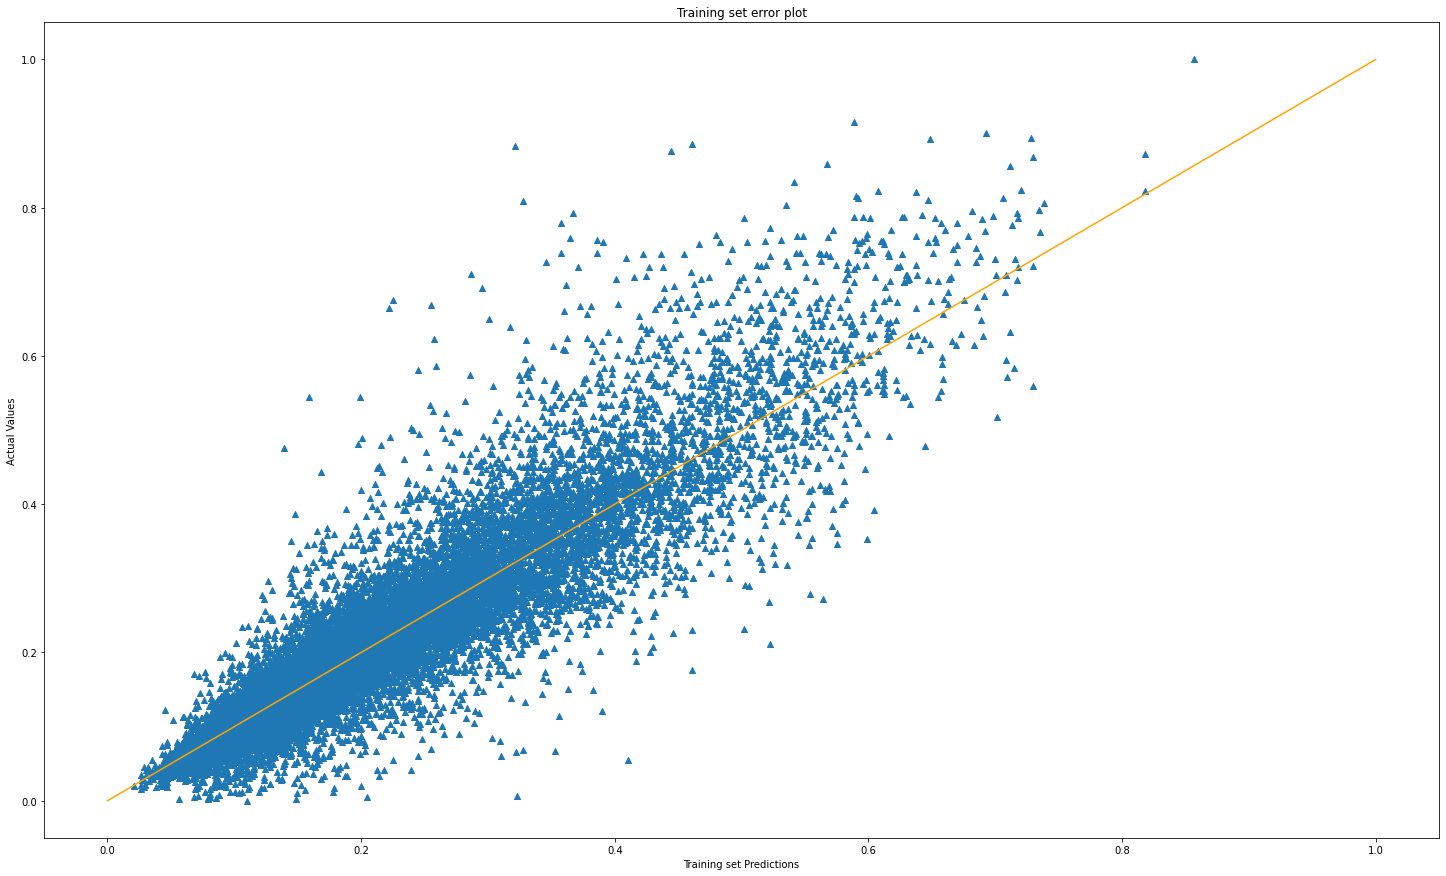

In [58]:

##KNN Training
KNNtrain_pred = train_preds

plt.figure(figsize=(25, 15))

plt.scatter(train_preds, y_train, marker="^")

plt.plot([0,1], color="orange")

plt.xlabel("Training set Predictions")

plt.ylabel("Actual Values")

plt.title("Training set error plot")

plt.show()

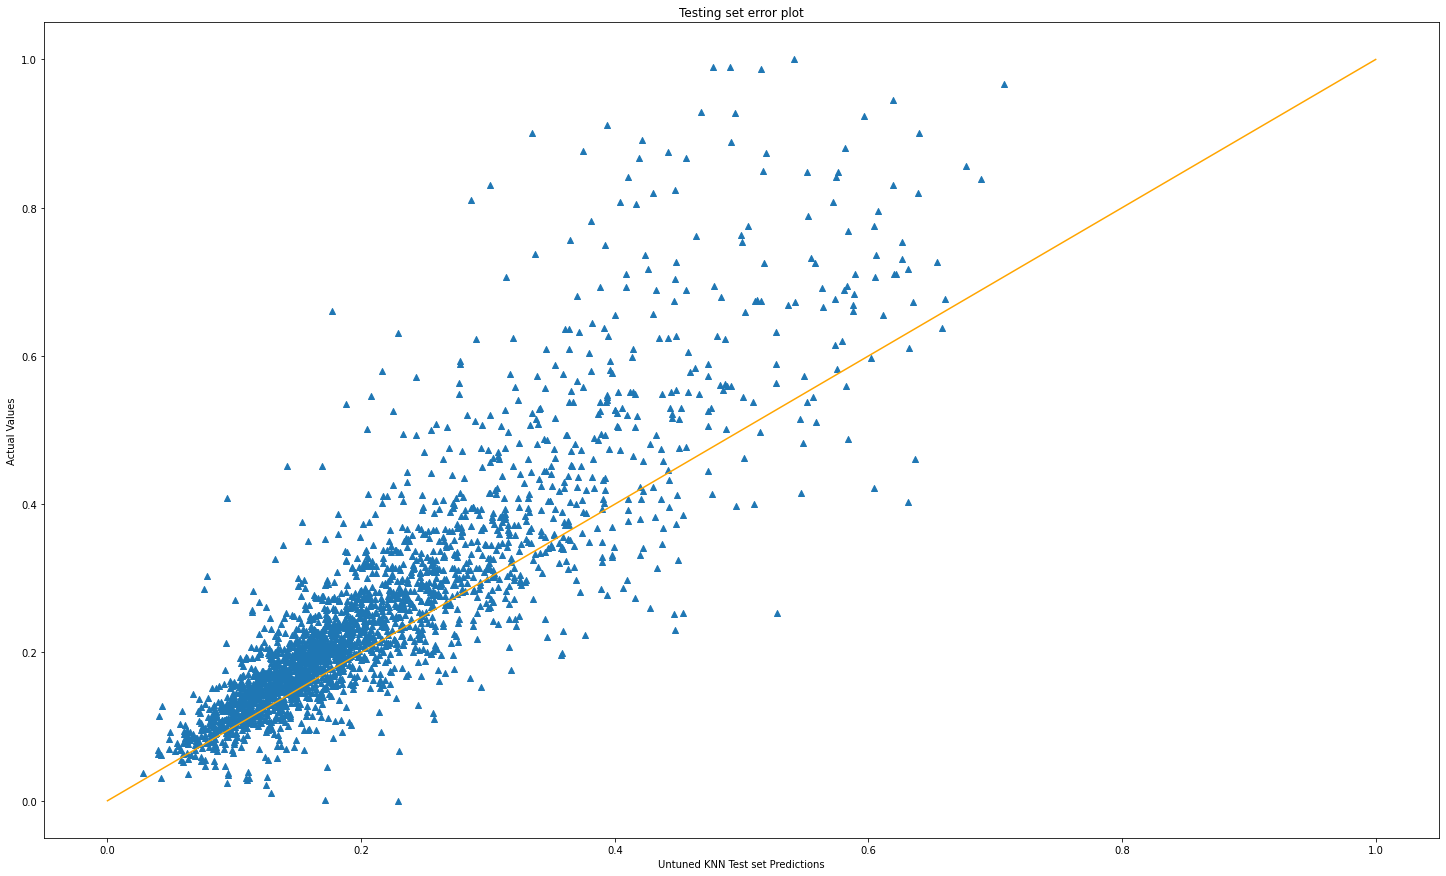

In [59]:

#KNN Testing

KNN_test = test_preds

plt.figure(figsize=(25, 15))

plt.scatter(test_preds, y_test, marker="^")

plt.plot([0,1], color="orange")

plt.xlabel("Untuned KNN Test set Predictions")

plt.ylabel("Actual Values")

plt.title("Testing set error plot")

plt.show()

In [60]:

###TUNING###


In [61]:

############################################### Getting Rid Of Rows Where Price Is More Than 6.25 STD Away From Median #################################################
# Calculate the median of 'ADJUSTED_PRICE'
median = X_train_1['ADJUSTED_PRICE'].median()

# Calculate the standard deviation of 'ADJUSTED_PRICE'
std_dev = X_train_1['ADJUSTED_PRICE'].std()

# Create a boolean mask to identify rows where 'ADJUSTED_PRICE' is more than 6.25 standard deviations away from the median
mask = (X_train_1['ADJUSTED_PRICE'] < (median - 2 * std_dev)) | (X_train_1['ADJUSTED_PRICE'] > (median + 6.25 * std_dev))

# Remove rows where 'ADJUSTED_PRICE' is more than 2 standard deviations away from the median
X_train_1 = X_train_1[~mask]

#Making new Y with removed rows
y_train_1 = X_train_1['ADJUSTED_PRICE']

#Dropping Unessercary Rows
X_train_1 = X_train_1.drop(columns=['ADJUSTED_PRICE', 'SUBURB', 'NEAREST_STN', 'NEAREST_SCH'], axis=1)


#Scaling All Values

minmax = MinMaxScaler()
minmax_y = MinMaxScaler()
y_train_unscaled = y_train_1


X_train_1[list(X_train_1.columns)] = minmax.fit_transform(X_train_1[list(X_train_1.columns)])
y_train_1=minmax_y.fit_transform(pd.DataFrame({'price':y_train_1}))

######################################################################################################################################################################


**KNN Regressor after optimising neighbors**

In [62]:

rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K, p=1, weights = 'distance')

    model.fit(X_train_1, y_train_1)  #fit the model
    pred=model.predict(X_valid) #make prediction on validation set
    error = sqrt(mean_squared_error(y_valid_unscaled,minmax_y.inverse_transform(pred))) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 243537.81997395735
RMSE value for k=  2 is: 216890.89768904052
RMSE value for k=  3 is: 206654.61084873756
RMSE value for k=  4 is: 203349.98387768175
RMSE value for k=  5 is: 201394.3144492002
RMSE value for k=  6 is: 199813.426486229
RMSE value for k=  7 is: 198926.30665067263
RMSE value for k=  8 is: 199115.9418780023
RMSE value for k=  9 is: 198581.08334322736
RMSE value for k=  10 is: 198712.65301379474
RMSE value for k=  11 is: 198311.90400205323
RMSE value for k=  12 is: 198404.54516496276
RMSE value for k=  13 is: 198631.22593073992
RMSE value for k=  14 is: 199212.5262019932
RMSE value for k=  15 is: 199833.5329540853
RMSE value for k=  16 is: 200502.30083790678
RMSE value for k=  17 is: 201102.04692137503
RMSE value for k=  18 is: 201754.0747726948
RMSE value for k=  19 is: 202493.75820063564
RMSE value for k=  20 is: 203002.29277171826


In [63]:

Tuned_KNNregressor= KNeighborsRegressor(n_neighbors = 7 , p=1, weights = 'distance')
#Tuned_KNNregressor= KNeighborsRegressor()
Tuned_KNNregressor.fit(X_train_1, y_train_1)

KNeighborsRegressor(n_neighbors=7, p=1, weights='distance')

In [64]:

print("###################### Tuned K Nearest Neighbour ######################")

print("\n")
print("############################################")
print("\n")

test_preds = Tuned_KNNregressor.predict(X_test)
mse = mean_squared_error(y_test_unscaled, minmax_y.inverse_transform(test_preds))
rmse = sqrt(mse)
mae =  mean_absolute_percentage_error(y_test_unscaled, minmax_y.inverse_transform(test_preds))
r2 =  r2_score(y_test, test_preds)

print("Test data prediction accuracy")
#print("MSE",mse)
print("RMSE",round(rmse, 2),"AUD")
print("MAPE",round(mae, 2)*100,"%")
print("r2_score",round(r2*100, 2),"%")

print("\n")
print("############################################")
print("\n")

train_preds = Tuned_KNNregressor.predict(X_train_1)
mse = mean_squared_error(y_train_unscaled, minmax_y.inverse_transform(train_preds))
rmse = sqrt(mse)
mae = mean_absolute_percentage_error(y_train_unscaled,  minmax_y.inverse_transform(train_preds))
r2 =  r2_score(y_train_1, train_preds)
print("Training data prediction accuracy")
#print("MSE",mse)
print("RMSE",round(rmse, 2),"AUD")
print("MAPE",round(mae, 2)*100,"%")
print("r2_score",round(r2*100, 2),"%")

print("\n")
print("############################################")
print("\n")

valid_preds = Tuned_KNNregressor.predict(X_valid)
mse = mean_squared_error(y_valid_unscaled, minmax_y.inverse_transform(valid_preds))
rmse = sqrt(mse)
mae = mean_absolute_percentage_error(y_valid_unscaled, minmax_y.inverse_transform(valid_preds))
r2 =  r2_score(y_valid, valid_preds)
print("Validation data prediction accuracy")
#print("MSE",mse)
print("RMSE",round(rmse, 2),"AUD")
print("MAPE",round(mae, 2)*100,"%")
print("r2_score",round(r2*100, 2),"%")


print("\n")
print("############################################")
print("\n")


###################### Tuned K Nearest Neighbour ######################


############################################


Test data prediction accuracy
RMSE 187215.91 AUD
MAPE 20.0 %
r2_score 74.24 %


############################################


Training data prediction accuracy
RMSE 502.83 AUD
MAPE 0.0 %
r2_score 100.0 %


############################################


Validation data prediction accuracy
RMSE 198926.31 AUD
MAPE 17.0 %
r2_score 68.79 %


############################################




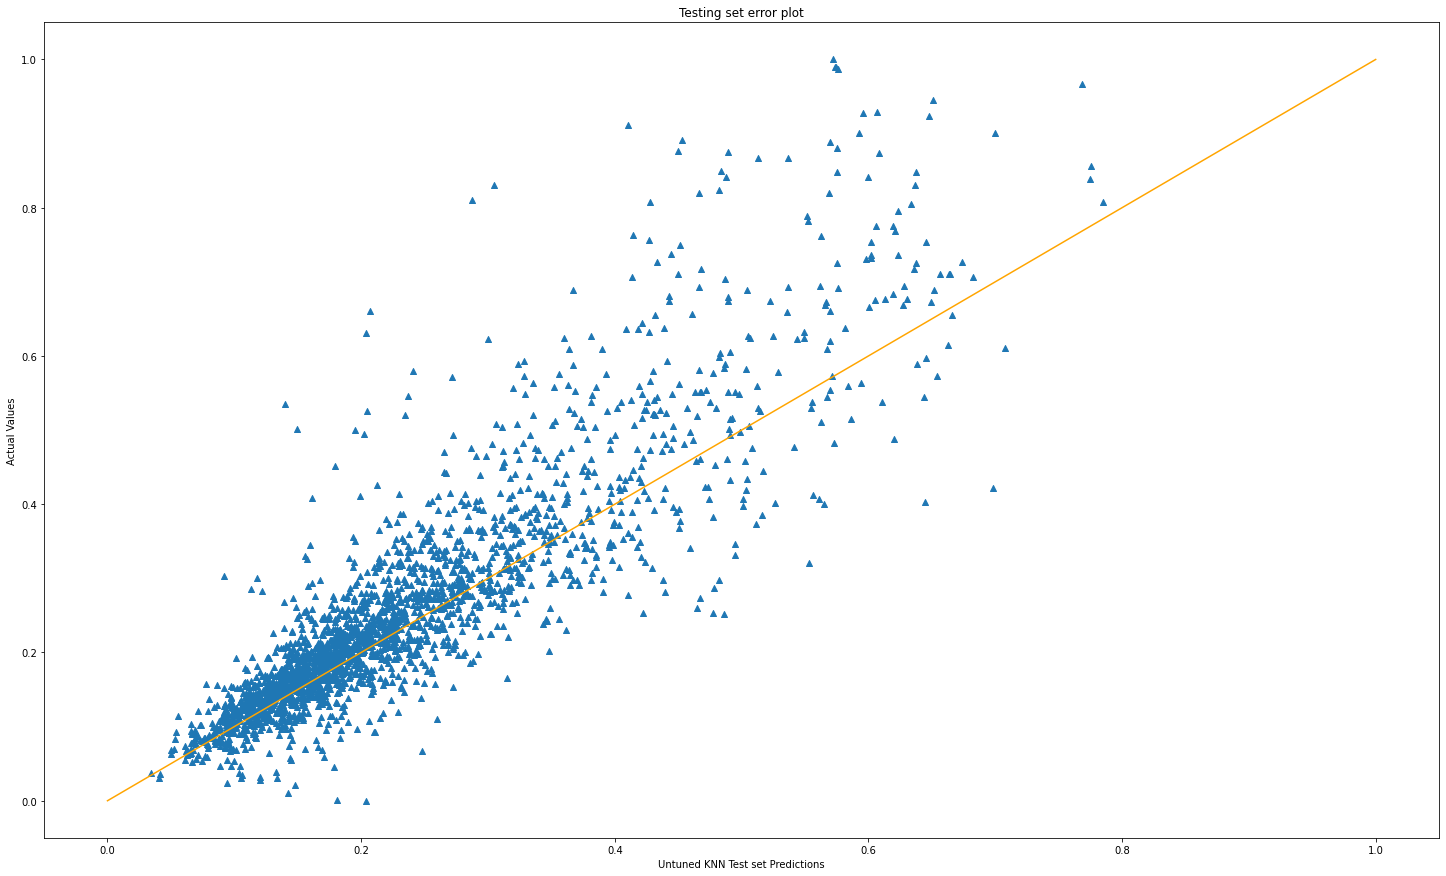

In [65]:

#KNN Testing

KNNTUNED_test = test_preds

plt.figure(figsize=(25, 15))

plt.scatter(test_preds, y_test, marker="^")

plt.plot([0,1], color="orange")

plt.xlabel("Untuned KNN Test set Predictions")

plt.ylabel("Actual Values")

plt.title("Testing set error plot")

plt.show()

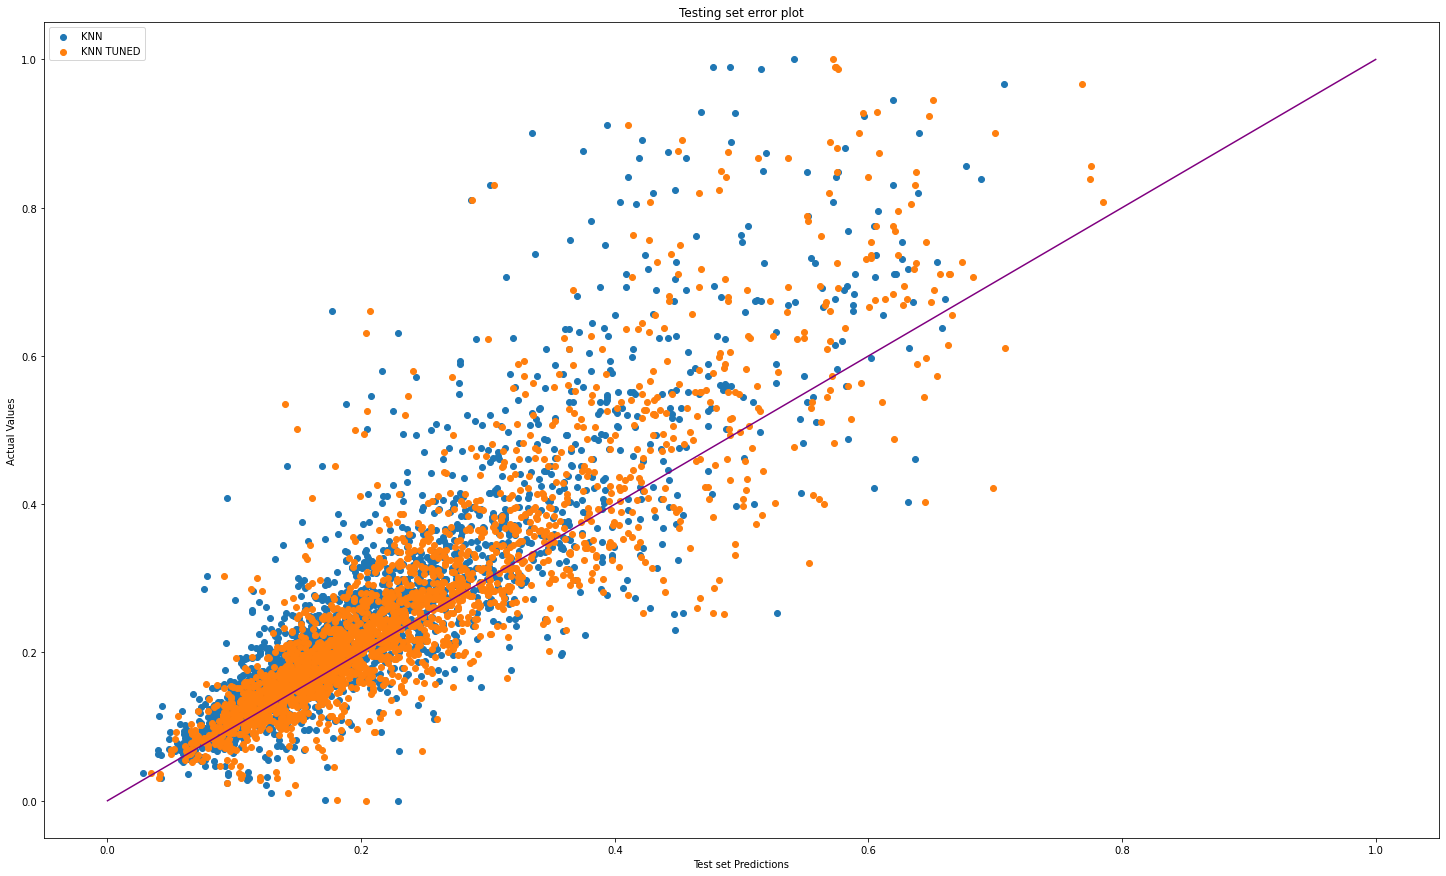

In [66]:

plt.figure(figsize=(25, 15))

plt.scatter(KNN_test, y_test, label = 'KNN')
plt.scatter(KNNTUNED_test, y_test, label = 'KNN TUNED')

plt.plot([0,1], color="purple")

plt.legend()

plt.xlabel("Test set Predictions")

plt.ylabel("Actual Values")

plt.title("Testing set error plot")

plt.show()

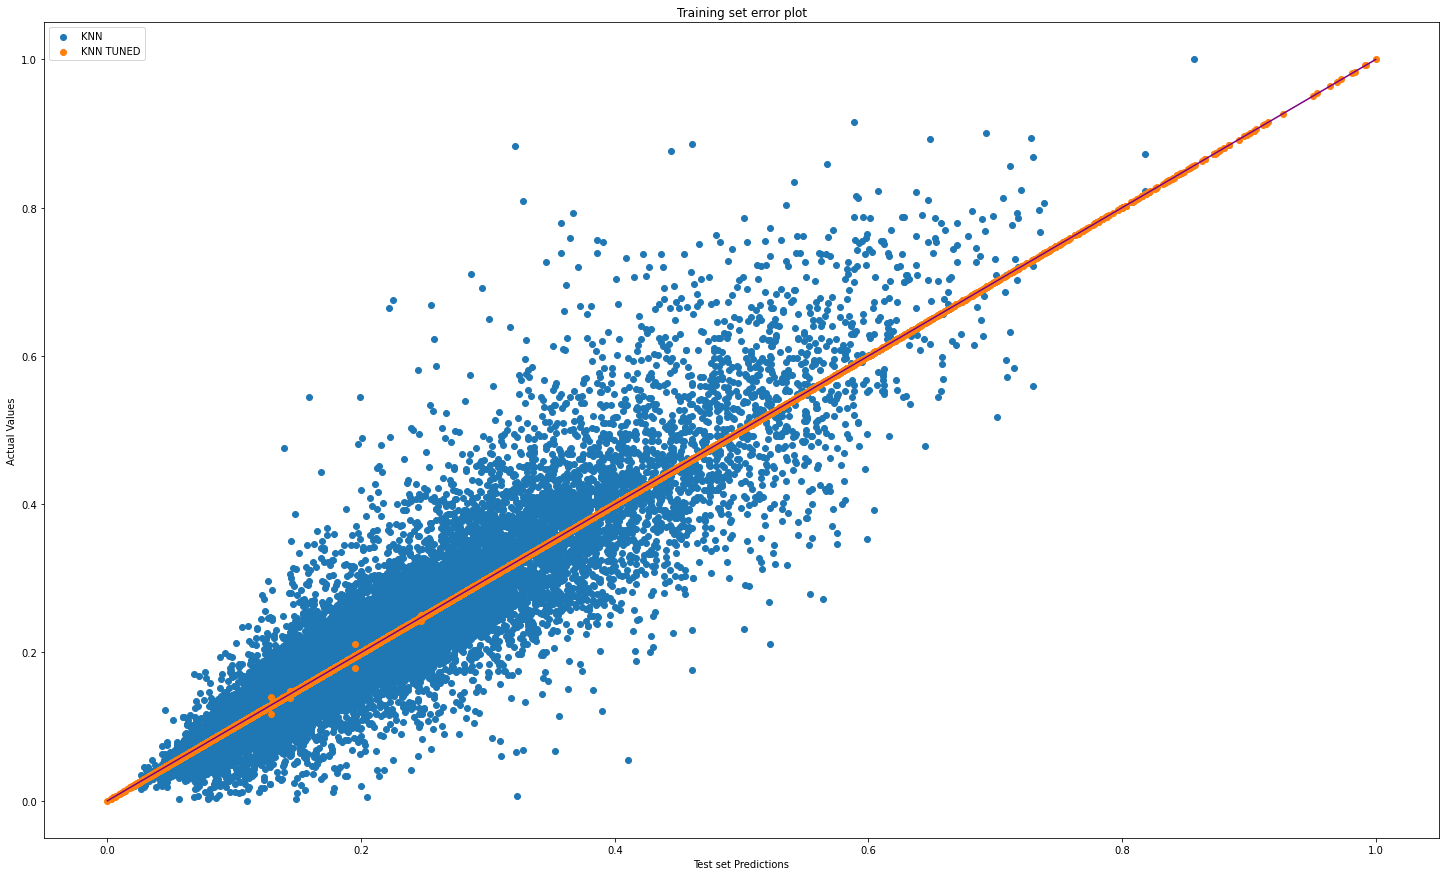

In [67]:

plt.figure(figsize=(25, 15))

plt.scatter(KNNtrain_pred, y_train, label = 'KNN')
plt.scatter(train_preds, y_train_1, label = 'KNN TUNED')

plt.plot([0,1], color="purple")

plt.legend()

plt.xlabel("Test set Predictions")

plt.ylabel("Actual Values")

plt.title("Training set error plot")

plt.show()